# Walk Through of Expectation - Maximization Algorithms

This notebook is slightly modified from: http://nbviewer.jupyter.org/github/BlackArbsCEO/Mixture_Models/blob/K-Means,-E-M,-Mixture-Models/E-M,%20K-Means,%20Mixture%20Models.ipynb


The high level take away is to think of Expectation Maximization as an iterative algorithm where in one place the function describing a cluster can be either a distance function, a Gaussian, or any custom function that takes in a set of points and returns a new 'centroid.'

while (centroids moved during last iteration):

    # Assign each point to the most 'Expected' centroid
    
    # Update the centroids to 'Maximize' their representation of assigned points
    
    
In K-Means the most 'Expected' centroid is the closest one. The way to 'Maximize' representation of a centroid and its assigned points is to place the centroid in the middle of the points.

In Gaussian Mixture Models the most 'Expected' centroid is the one with the highest likelihood of generating that point based on a Gaussian distribution originating from each centroid. The way to 'Maximize' representation of a centroid and its assigned points is to place the centroid in the middle of the points and designate the coverage in different dimentions.

A more indepth explanation: https://courses.cs.washington.edu/courses/cse312/11wi/slides/12em.pdf

In [1]:
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import pandas as pd
import pandas_datareader.data as web # pip install pandas_datareader
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### To gain understanding of mixture models we have to start at the beginning with the expectation maximization algorithm and it's application

### First a little history on E-M

Reference: 4

Demptser, Laird & Rubin (1977)
    -unified previously unrelated work under "The EM Algorithm"
    - unified previously unrelated work under "The EM Algorithm"
    - overlooked E-M works - see gaps between foundational authors
        - Newcomb (1887)
        - McKendrick (1926) [+39 years]
        - Hartley (1958) [+32 years]
        - Baum et. al. (1970) [+12 years]
        - Dempters et. al. (1977) [+7 years]

#### *EM Algorithm developed over 90 years*

## EM provides general framework for solving problems

Examples include:
    - Filling in missing data from a sample set
    - Discovering values of latent variables
    - Estimating parameters of HMMs
    - Estimating parameters of finite mixtures [models]
    - Unsupervised learning of clusters
    - etc...
    
### How does the EM algorithm work? 

EM is an iterative process that begins with a "naive" or random initialization and then alternates between the expectation and maximization steps until the algorithm reaches convergence. 

To describe this in words imagine we have a simple data set consisting of class heights with groups separated by gender.

In [42]:
# import class heights
f = 'https://raw.githubusercontent.com/BlackArbsCEO/Mixture_Models/K-Means%2C-E-M%2C-Mixture-Models/Class_heights.csv'

data = pd.read_csv(f)
# data.info()

height = data['Height (in)']
data

,Gender,Height (in)
0,Male,72
1,Male,72
2,Female,63
3,Female,62
4,Female,62
5,Male,73
6,Female,64
7,Female,63
8,Female,67
9,Male,71


Now imagine that we did not have the convenient gender labels associated with each data point. How could we estimate the two group means? 

First let's set up our problem. 

In this example we hypothesize that these height data points are drawn from two distributions with two means - < $\mu_1$, $\mu_2$ >.

The heights are the observed $x$ values. 

The hidden variables, which EM is going to estimate, can be thought of in the following way. Each $x$ value has 2 associated $z$ values. These $z$ values < $z_1$, $z_2$ > represent the distribution (or class or cluster) that the data point is drawn from.

Understanding the range of values the $z$ values can take is important. 

In k-means, the two $z$'s can only take the values of 0 or 1. If the $x$ value came from the first distribution (cluster), then $z_1$=1 and $z_2$=0 and vice versa. This is called **hard** clustering. 

In Gaussian Mixture Models, the $z$'s can take on any value between 0 and 1 because the x values are considered to be drawn probabilistically from 1 of the 2 distributions. For example $z$ values can be $z_1$=0.85 and $z_2$>=0.15, which represents a strong probability that the $x$ value came from distribution 1 and smaller probability that it came from distribution 2. This is called **soft** or **fuzzy** clustering. 


For this example, we will assume the x values are drawn from Gaussian distributions. 

To start the algorithm, we choose two random means. 

From there we repeat the following until convergence. 

#### The expectation step:

We calculate the expected values $E(z_{ij})$, which is the probability that $x_i$ was drawn from the $jth$ distribution.
    
$$E(z_{ij}) = \frac{p(x = x_i|\mu = \mu_j)}{\sum_{n=1}^2 p(x = x_i|\mu = \mu_j)}$$


$$= \frac{ e^{-\frac{1}{2\sigma^2}(x_i - \mu_j)^2} }
{ \sum_{n=1}^2e^{-\frac{1}{2\sigma^2}(x_i - \mu_n)^2} }$$

The formula simply states that the expected value for $z_{ij}$ is the probability $x_i$ given $\mu_j$ divided by the sum of the probabilities that $x_i$ belonged to each $\mu$

#### The maximization step:

After calculating all $E(z_{ij})$ values we can calculate (update) new $\mu$ values. 

$$ \mu_j = \frac {\sum_{i=1}^mE(z_{ij})x_i} {\sum_{i=1}^mE(z_{ij})}$$

This formula generates the maximum likelihood estimate. 

By repeating the E-step and M-step we are guaranteed to find a local maximum giving us a maximum likelihood estimation of our hypothesis. 

### What are Maximum Likelihood Estimates (MLE)

    1. Parameters describe characteristics (attributes) of a population. These parameter values are estimated from samples collected from that population.

    2. A MLE is a parameter estimate that is most consistent with the sampled data. By definition it maximizes the likelihood function. One way to accomplish this is to take the first derivative of the likelihood function w/ respect to the parameter theta and solve for 0. This value maximizes the likelihood function and is the MLE

### A quick example of a maximum likelihood estimate
    
#### You flip a coin 10 times and observe the following sequence (H, T, T, H, T, T, T, T, H, T)
#### What's the MLE of observing 3 heads in 10 trials?    

#### simple answer:    
    The frequentist MLE is (# of successes) / (# of trials) or 3/10

#### solving first derivative of binomial distribution answer:    

\begin{align}
\mathcal L(\theta) & = {10 \choose 3}\theta^3(1-\theta)^7 \\[1ex]
log\mathcal L(\theta) & = log{10 \choose 3} + 3log\theta + 7log(1 - \theta) \\[1ex]
\frac{dlog\mathcal L(\theta)}{d(\theta)} & = \frac 3\theta - \frac{7}{1-\theta} = 0 \\[1ex]
\frac 3\theta & = \frac{7}{1 - \theta} \Rightarrow \frac{3}{10}
\end{align}

#### That's a MLE! This is the estimate that is most consistent with the observed data

Back to our height example. Using the generalized Gaussian mixture model code sourced from Duke's computational statistics we can visualize this process. 

In [3]:
# Code sourced from:
#    http://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        
        xx = np.linspace(0, 100, 100)
        yy = scs.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_1$: {new_mus[0]:3.2f}', 
                    fontsize=12, fontweight='demi',
                    xy=(new_mus[0], (hi-lo) / 2), 
                    xycoords='data', xytext=(80, (hi-lo) / 2),
                    arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = scs.multivariate_normal.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_2$: {new_mus[1]:3.2f}', 
                    fontsize=12, fontweight='demi',
            xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
            arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        print(f'log_likelihood: {ll_new:3.4f}')
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas


Iteration:  0

               1           2
mus    61.362928   59.659685
sigs  469.240750  244.382352
log_likelihood: -141.8092

Iteration:  1

              1          2
mus    68.73773  63.620554
sigs  109.85442   7.228183
log_likelihood: -118.0520

Iteration:  2

              1          2
mus   70.569842  63.688825
sigs   4.424452   3.139277
log_likelihood: -100.2591

Iteration:  3

              1          2
mus   70.569842  63.688825
sigs   4.424427   3.139278
log_likelihood: -100.2591


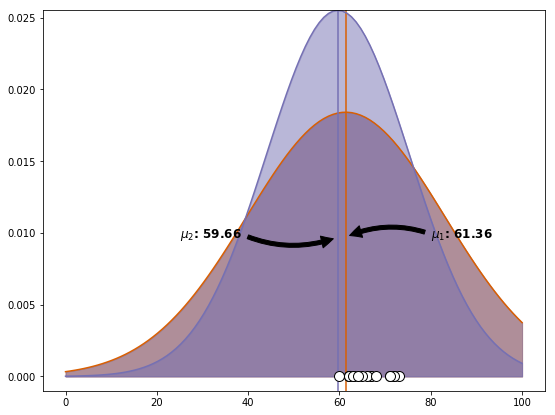

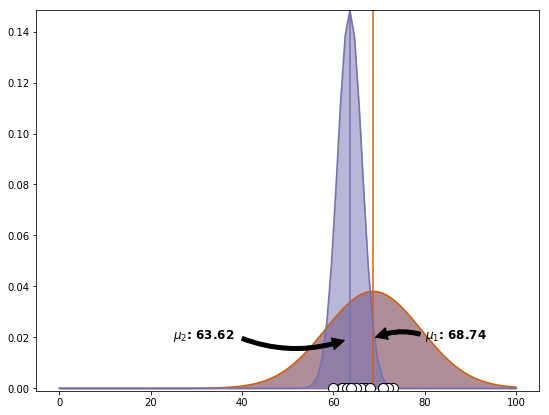

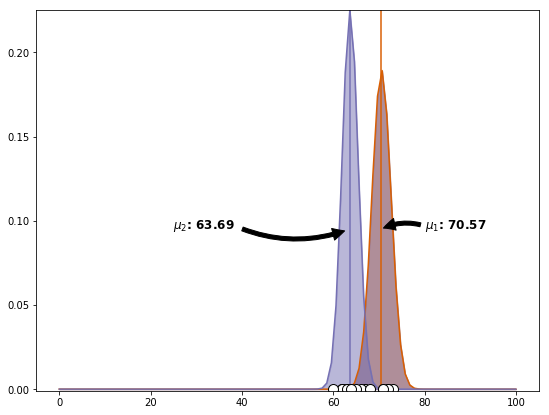

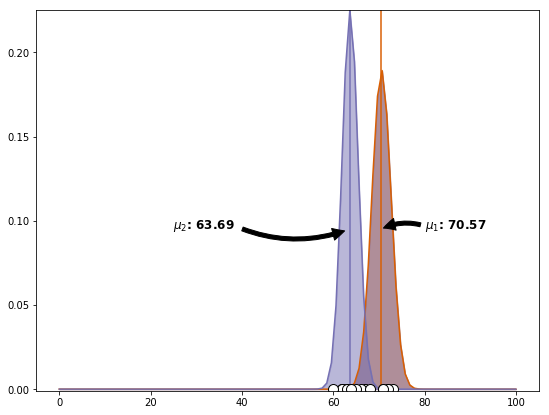

In [4]:
height = data['Height (in)']
n = len(height)

# Ground truthish
_mus = np.array([[0, data.groupby('Gender').mean().iat[0, 0]], 
                 [data.groupby('Gender').mean().iat[1, 0], 0]])
_sigmas = np.array([[[5, 0], [0, 5]], 
                    [[5, 0],[0, 5]]])
_pis = np.array([0.5, 0.5]) # priors

# initial random guesses for parameters
np.random.seed(0)

pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2) * height.std()

# generate our noisy x values
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

ll, pis, mus, sigmas = em_gmm_orig(xs, pis, mus, sigmas)

# In the below plots the white dots represent the observed heights.

#### Notice how the algorithm was able to estimate the true means starting from random guesses for the parameters.

### Now that we have a grasp of the algorithm we can examine K-Means as a form of EM

K-Means is an unsupervised learning algorithm used for clustering multidimensional data sets.

The basic form of K-Means makes two assumptions

    1. Each data point is closer to its own cluster center than the other cluster centers
    2. A cluster center is the arithmetic mean of all the points that belong to the cluster.

The expectation step is done by calculating the pairwise distances  of every data point and assigning cluster membership to the closest center (mean)

The maximization step is simply the arithmetic mean of the previously assigned data points for each cluster

#### The following sections borrow heavily from Jake Vanderplas' [Python Data Science Handbook](https://www.amazon.com/gp/product/1491912057/ref=as_li_qf_sp_asin_il_tl?ie=UTF8&tag=blkarbs-20&camp=1789&creative=9325&linkCode=as2&creativeASIN=1491912057&linkId=e000ed9627cfe6b505be11c50118decb)

In [5]:
# Let's define some demo variables and make some blobs

# demo variables

k = 4
n_draws = 500
sigma = .7
random_state = 0
dot_size = 50
cmap = 'viridis'

Text(0.5,1,'k-means make blobs')

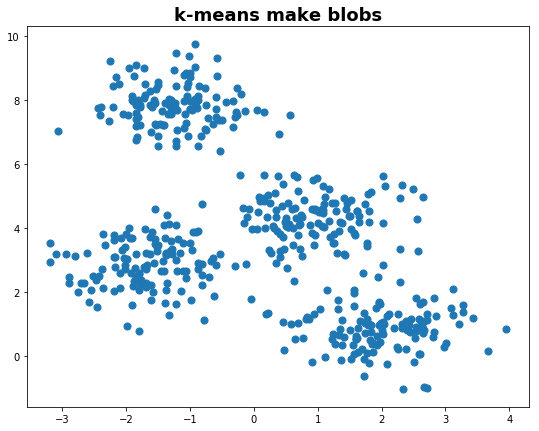

In [6]:
# make blobs

from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples = n_draws,
                       centers = k,
                       cluster_std = sigma,
                       random_state = random_state)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], s=dot_size)
plt.title('k-means make blobs', fontsize=18, fontweight='demi')

In [7]:
# sample implementation
# code sourced from: 
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

Text(0.5,1,'find_clusters() k-means func')

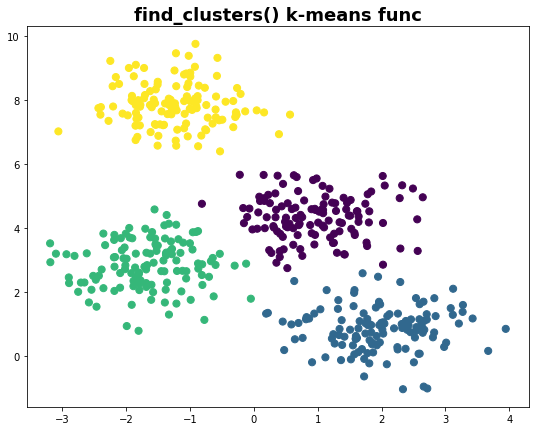

In [8]:
# let's test the implementation

centers, labels = find_clusters(X, k)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap)
plt.title('find_clusters() k-means func', fontsize=18, fontweight='demi')

Text(0.5,1,'sklearn k-means')

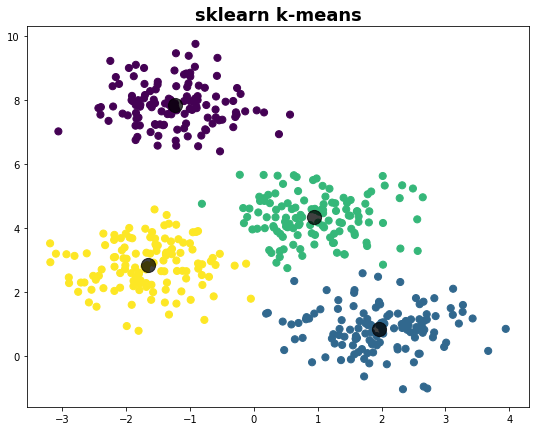

In [9]:
# now let's compare this to the sklearn's KMeans() algorithm

# fit k-means to blobs

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# visualize prediction
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

# get centers for plot
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
plt.title('sklearn k-means', fontsize=18, fontweight='demi')

#### To build our intuition of this process, play with the following interactive code from Jake Vanderplas in an Jupyter (IPython) notebook

In [14]:
# code sourced from:
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Covariance-Type

from ipywidgets import interact

def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)
        
    def plot_points(X, labels, n_clusters):
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis',
                    vmin=0, vmax=n_clusters - 1);
            
    def plot_centers(centers):
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c=np.arange(centers.shape[0]),
                    s=200, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c='black', s=50)
            

    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        # plot the data and cluster centers
        plot_points(X, labels, n_clusters)
        plot_centers(old_centers)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], 
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plot_centers(centers)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                     ha='right', va='top', size=14)
    
    return interact(_kmeans_step,
                    frame=range(0, 200, 10),
                    n_clusters=range(min_clusters, max_clusters * 2))

plot_kmeans_interactive();

A Jupyter Widget

### Now we are ready to explore some of the nuances/issues of implementing K-Means as an expectation maximization algorithm

### the globally optimal result is not guaranteed
    - EM is guaranteed to improve the result in each iteration but there are no guarantees that it will find the global best. See the following example, where we initalize the algorithm with a different seed.

### practical solution: 
    - Run the algorithm w/ multiple random initializations
    - This is done by default in sklearn

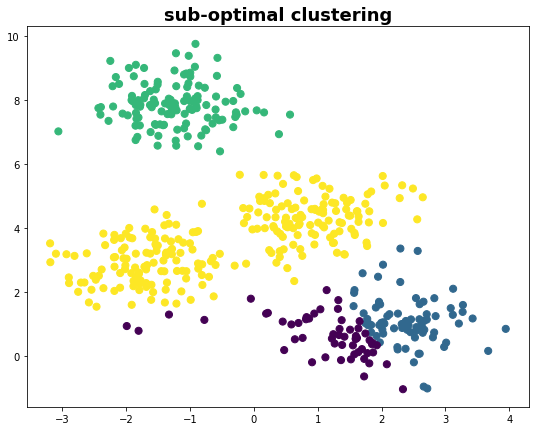

In [15]:
centers, labels = find_clusters(X, k, rseed=11)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('sub-optimal clustering', fontsize=18, fontweight='demi')
ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap)

### number of means (clusters) have to be selected beforehand
    - k-means cannot learn the optimal number of clusters from the data. If we ask for six clusters it will find six clusters, which may or may not be meaningful.
    
### practical solution:
    - use a more complex clustering algorithm like Gaussian Mixture Models, or one that can choose a suitable number of clusters (DBSCAN, mean-shift, affinity propagation)

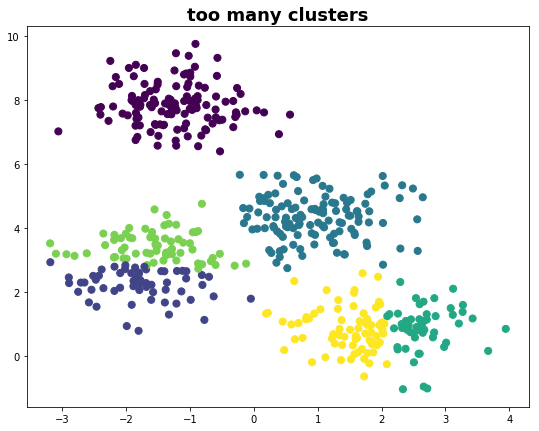

In [16]:
labels6 = KMeans(6, random_state=random_state).fit_predict(X)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('too many clusters', fontsize=18, fontweight='demi')
ax.scatter(X[:, 0], X[:, 1], c=labels6, s=dot_size, cmap=cmap)

### k-means is terrible for non-linear data:
    - this results because of the assumption that points will be closer to their own cluster center than others

### practical solutions:
    - transform data into higher dimension where linear separation is possible e.g., spectral clustering

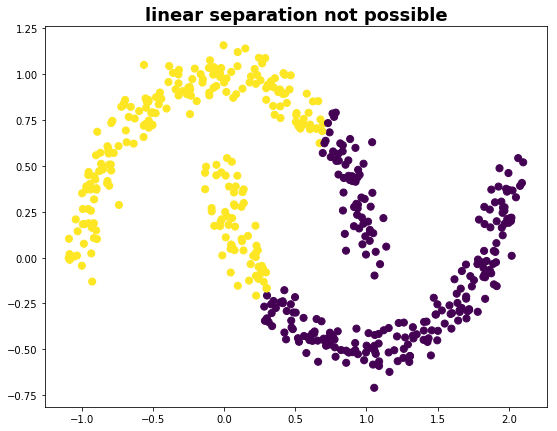

In [17]:
from sklearn.datasets import make_moons

X_mn, y_mn = make_moons(500, noise=.07, random_state=random_state)

labelsM = KMeans(2, random_state=random_state).fit_predict(X_mn)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('linear separation not possible', fontsize=18, fontweight='demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1], c=labelsM, s=dot_size, cmap=cmap)

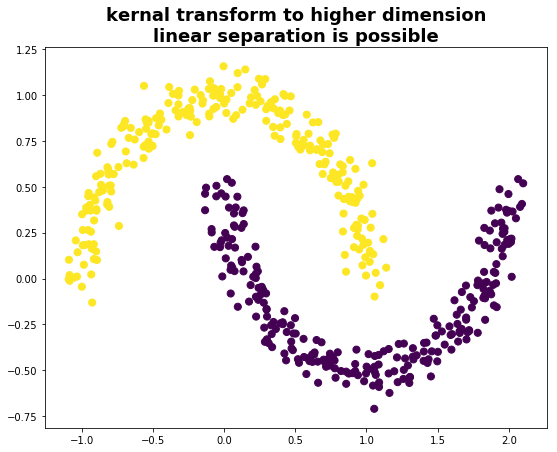

In [18]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                          assign_labels='kmeans')

labelsS = model.fit_predict(X_mn)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('kernal transform to higher dimension\nlinear separation is possible', fontsize=18, fontweight='demi')
plt.scatter(X_mn[:, 0], X_mn[:, 1], c=labelsS, s=dot_size, cmap=cmap)

### K-Means is known as a hard clustering algorithm because clusters are not allowed to overlap.  

> ___"One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.___ -- <cite> [Jake VanderPlas Python Data Science Handbook] [1]</cite>

[1]:http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb

Text(0.5,1,'Clusters are hard circular boundaries')

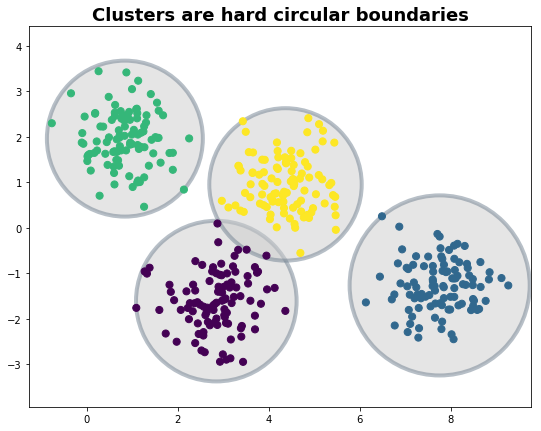

In [19]:
# k-means weaknesses that mixture models address directly
# code sourced from:
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=k, rseed=2, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot input data
    #ax = ax or plt.gca() # <-- nice trick
    fig, ax = plt.subplots(figsize=(9,7))    
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1],
               c=labels, s=dot_size, cmap=cmap, zorder=2)
    
    # plot the representation of Kmeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels==i], [center]).max() 
             for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC',edgecolor='slategrey',
                                lw=4, alpha=0.5, zorder=1))
    return      
                     
X3, y_true = make_blobs(n_samples = 400,
                       centers = k,
                       cluster_std = .6,
                       random_state = random_state)
X3 = X3[:, ::-1] # better plotting

kmeans = KMeans(n_clusters=k, random_state=random_state)
plot_kmeans(kmeans, X3)
plt.title('Clusters are hard circular boundaries', fontsize=18, fontweight='demi')

#### A resulting issue of K-Means' circular boundaries is that it has no way to account for oblong or elliptical clusters. 

Text(0.5,1,'Clusters cannot adjust to elliptical data structures')

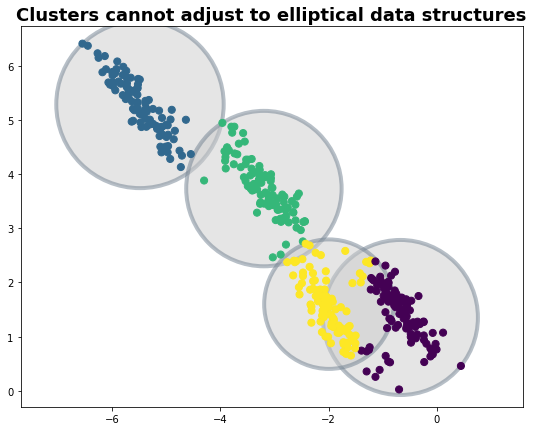

In [20]:
rng = np.random.RandomState(13)
X3_stretched = np.dot(X3, rng.randn(2, 2))

kmeans = KMeans(n_clusters=k, random_state=random_state)
plot_kmeans(kmeans, X3_stretched)
plt.title('Clusters cannot adjust to elliptical data structures',
         fontsize=18, fontweight='demi')

### There are two ways we can extend K-Means

    1. measure uncertainty in cluster assignments by comparing distances to all cluster centers
    2. allow for flexibility in the shape of the cluster boundaries by using ellipses

### Recall our previous height example, and let's  assume that each cluster is a Gaussian distribution!

#### Gaussian distributions give flexibility to the clustering, and the same basic two step E-M algorithm used in K-Means is applied here as well. 

1. Randomly initialize location and shape
2. Repeat until converged:
       E-step: for each point, find weights encoding the probability of membership in each cluster.
       
       M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
       
#### The result of this process is that we end up with a smooth Gaussian cluster better fitted to the shape of the data, instead of a rigid inflexible circle. 

#### Note that because we still are using the E-M algorithm there is no guarantee of a globally optimal result. We can visualize the results of the model. 

In [34]:
# code sourced from:
#  http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb
from matplotlib.patches import Ellipse 

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                            angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    
    fig, ax = plt.subplots(figsize=(9,9))
    plt.axis('equal')
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap, zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=dot_size, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax=ax, alpha=w * w_factor)

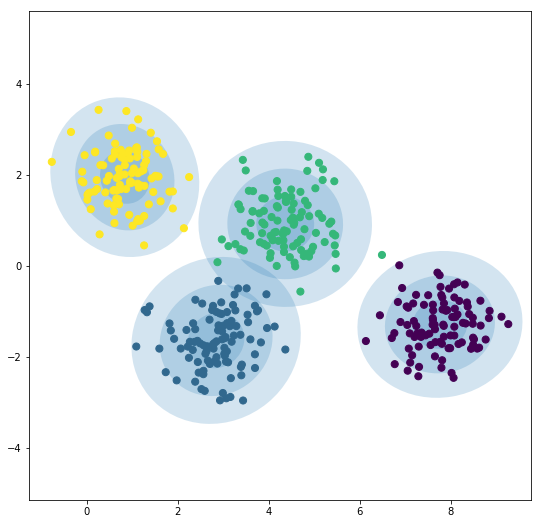

In [35]:
gmm = mix.GaussianMixture(n_components=k, random_state=random_state)
plot_gmm(gmm, X3)

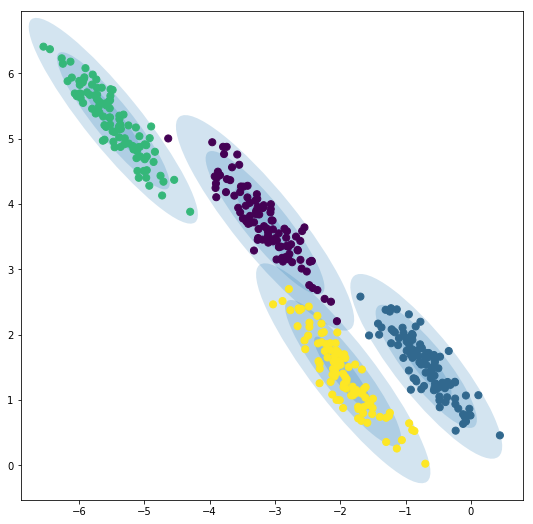

In [36]:
# lets test on the stretched data set

gmm = mix.GaussianMixture(n_components=k, random_state=random_state+1)
plot_gmm(gmm, X3_stretched)

#### Notice how much better the model is able to fit the clusters when we assume each cluster is a Gaussian distribution instead of circle whose radius is defined by the most distant point.

## Gaussian Mixture Models as a tool for Density Estimation

#### The technical term for this type of model is: 

> __generative probabilistic model__

#### Why you ask? 

Because this model is really about characterizing the distribution of the entire dataset and not necessarily clustering. The power of these types of models is that they allow us to generate __new__ samples that __mimic__ the original underlying data!

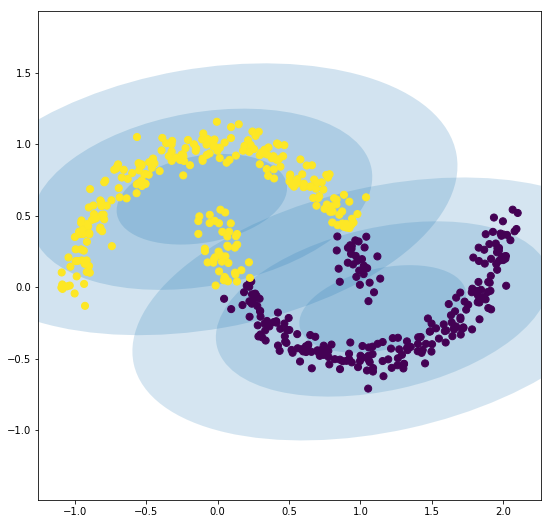

In [37]:
gmm2 = mix.GaussianMixture(n_components=2, covariance_type='full',
                          random_state=random_state)
plot_gmm(gmm2, X_mn)

If we try to cluster this data set we run into the same issue as before.

Instead let's ignore individual clusters and model the whole distribution of data as a collection of many Gaussians. 

Text(0.5,1,'Collective Gaussian clusters')

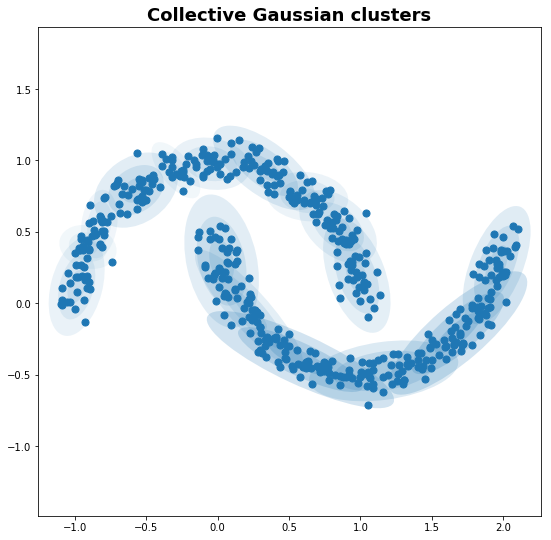

In [38]:
gmm16 = mix.GaussianMixture(n_components=16, covariance_type='full', 
                           random_state=random_state)

plot_gmm(gmm16, X_mn, label=False)
plt.title('Collective Gaussian clusters',
            fontsize=18, fontweight='demi')

Looks like the collection of clusters has fit the data set reasonably well. Now let's see if the model has actually _learned_ about this data set, such that we can create entirely new samples that _look_ like the original.

Text(0.5,1,'New samples drawn from fitted model')

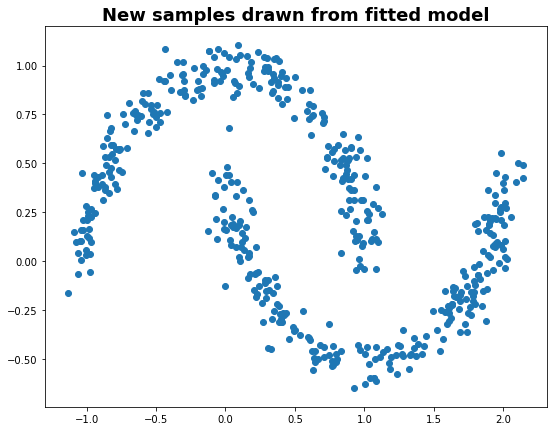

In [39]:
Xnew, ynew = gmm16.sample(500)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(Xnew[:, 0], Xnew[:, 1]);
ax.set_title('New samples drawn from fitted model',
            fontsize=18, fontweight='demi')

Generative models allow for multiple methods to determine optimal number of components. Because it is a probability distribution we can evaluate the likelihood of the data using cross validation and/or using AIC or BIC. Additional documentation on Bayesian Information Criterion and Akaike Information Criterion: https://en.wikipedia.org/wiki/Bayesian_information_criterion

Sklearn makes this easy.

Text(0.5,0,'n_components')

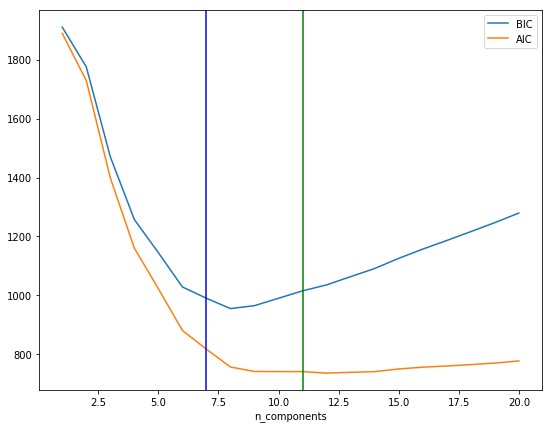

In [27]:
n_components = np.arange(1, 21)
models = [mix.GaussianMixture(n, covariance_type='full',
                             random_state=random_state).fit(X_mn)
         for n in n_components]

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(n_components, [m.bic(X_mn) for m in models], label='BIC')
ax.plot(n_components, [m.aic(X_mn) for m in models], label='AIC')
ax.axvline(np.argmin([m.bic(X_mn) for m in models]), color='blue')
ax.axvline(np.argmin([m.aic(X_mn) for m in models]), color='green')

plt.legend(loc='best')
plt.xlabel('n_components')

<h1>Exploration Time!</h1>

Rerun each of the above sections in your groups and ask questions about anything that is surprising.

Run the below code and get a sense for how covariance parameters influence GMM. For more documentation on covariance possibilities in sklearn see: http://scikit-learn.org/stable/modules/mixture.html

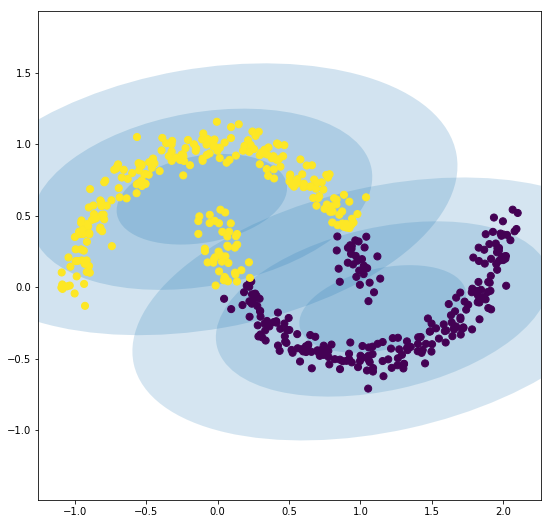

In [45]:
# TODO change covariance_type to full, diag, tied and understand how it changes the behavior of the GMM
my_gmm = mix.GaussianMixture(n_components=2, covariance_type='full',
                          random_state=random_state)
plot_gmm(my_gmm, X_mn)

If time - design your own algorithm!

Using the Expectation-Maximization iterative flow, think of a new way to update representing a set of points. What's a use case your algorithm would be good for? What's a use case it would fail during?